# Amazon Review Analysis and Classification

The training set for this analysis is the text from 100,000 reviews from Amazon.com, their timestamps, and their star ratings. The high level goal of this analysis is to use the textual and temporal data to predict the star ratings.

In [2]:
# import stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim import corpora
from gensim.models import LsiModel, KeyedVectors
import sklearn.model_selection as ms
from sklearn.ensemble import RandomForestClassifier
from datetime import *

In [3]:
# read stuff
reviews_dict = corpora.Dictionary.load("reviews.dict")
reviews_bow = corpora.MmCorpus('train_reviews.mm')
reviews_times  = np.load('train_times.npy')
reviews_times.shape = (len(reviews_bow),1)
reviews_wc = corpora.MmCorpus('reviews_wc.mm')
reviews_sppmi_300 = np.load('reviews_sppmi_300.npy')
reviews_wv = KeyedVectors.load("word_vectors.wv", mmap='r')
y = np.vstack((np.repeat(1, 4000), np.repeat(2, 4000), np.repeat(3, 4000), np.repeat(4, 4000), np.repeat(5, 4000)))
y = np.repeat(y, 5)

## Step 1: Word vectors

Performing several optimizations on a word-context shifted positive pointwise mutual information ($SPPMI$) matrix, including decomposing with SVD, is mathematically equivalent to a neural network that learns word embeddings using skip gram with negative sampling ($SGNS$).  We are going to implement each of these here and compare against a pure bag of words ($BOW$) model as a baseline.

To begin, let's make a corpus out of a toy dataset: the 5 computer science and 4 math article titles. After lower casing, tokenizing, and stop wording, the corpus looks like `titles` in the cell below. Then, we create a dictionary and a sparse document-term matrix.

In [4]:
titles = [['human', 'interface', 'computer'],
          ['survey', 'user', 'computer', 'system', 'response', 'time'],
          ['eps', 'user', 'interface', 'system'],
          ['system', 'human', 'system', 'eps'],
          ['user', 'response', 'time'],
          ['trees'],
          ['graph', 'trees'],
          ['graph', 'minors', 'trees'],
          ['graph', 'minors', 'survey']]

titles_dict = corpora.Dictionary(titles)
titles_bow = [titles_dict.doc2bow(title) for title in titles]
display(titles_bow)

[[(0, 1), (1, 1), (2, 1)],
 [(0, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(2, 1), (5, 1), (7, 1), (8, 1)],
 [(1, 1), (5, 2), (8, 1)],
 [(3, 1), (6, 1), (7, 1)],
 [(9, 1)],
 [(9, 1), (10, 1)],
 [(9, 1), (10, 1), (11, 1)],
 [(4, 1), (10, 1), (11, 1)]]

### Step 1.1: Sparse to dense

To get the term-document matrix, we need to convert this matrix to its dense form. We will write a function `densify` that takes as input:

1. a sparse matrix in the format of `titles_bow` above
3. an integer number of columns

and returns a NumPy array. Please note that `titles_bow` is a document-term matrix, not a term-document matrix, so we transpose it in the second cell below.

In [5]:
def densify(sparse, columns):
    orig = np.zeros((len(sparse), columns))
    count = 0
    for i in sparse:
        for j in i:
            orig[count][j[0]] = j[1]
        count += 1
    
    return orig

In [6]:
td = densify(titles_bow, len(titles_dict)).transpose()
print(td)

[[1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 2. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]]


In [7]:
print(td.shape)

(12, 9)


### Step 1.2: Counting words

We will write a function `count_words` that takes as input:

1. a dictionary in the format of `titles_dict` above
2. a bag of words corpus in the format of `titles_bow` above

and returns a list called `counts` that has the total occurrences of each word in the corpus, in the order of the original word indices.

In [8]:
def count_words(gsdict, gsbow):
    orig = np.zeros((len(gsbow), len(gsdict)))
    count = 0
    for i in gsbow:
        for j in i:
            orig[count][j[0]] = j[1]
        count += 1
    
    return np.sum(orig, axis=0).tolist()

In [9]:
titles_counts = count_words(titles_dict, titles_bow)
display(len(titles_counts))

12

In [10]:
display(titles_counts)

[2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 2.0, 3.0, 2.0, 3.0, 3.0, 2.0]

The cell below makes the counts for the 100,000 Amazon reviews.

In [11]:
reviews_counts = count_words(reviews_dict, reviews_bow)

### Step 1.3: The word-context matrix

Now, we will write a function `word_context` that takes as input:

1. a dictionary in the format of `titles_dict` above
2. a corpus in the format of `titles` above
3. a window size (integer)

and creates a **sparse** word-context matrix.

In [12]:
def word_context(gsdict, gscorpus, window):
    orig = np.zeros((len(gsdict), len(gsdict)))
    
    for doc in gscorpus:
        for i in range(len(doc)):
            for j in range(i-window, i+window+1):
                if j >=0 and j <= len(doc)-1 and j != i:
                    #print(j)
                    context = gsdict.doc2idx([doc[i]])[0]
                    #print(context)
                    word = gsdict.doc2idx([doc[j]])[0]
                    #print(word)
                    orig[word][context] += 1
    
    lst1 = []
    for i in orig:
        lst2 = []
        for word, count in enumerate(i):
            if count > 0:
                lst2.append((word, count))
        
        lst1.append(lst2)
    
    return lst1

In [13]:
titles_wc = word_context(titles_dict, titles, 2)
display(titles_wc)

[[(1, 1.0), (2, 1.0), (3, 1.0), (4, 1.0), (5, 1.0), (7, 1.0)],
 [(0, 1.0), (2, 1.0), (5, 2.0), (8, 1.0)],
 [(0, 1.0), (1, 1.0), (5, 1.0), (7, 1.0), (8, 1.0)],
 [(0, 1.0), (5, 1.0), (6, 2.0), (7, 1.0)],
 [(0, 1.0), (7, 1.0), (10, 1.0), (11, 1.0)],
 [(0, 1.0),
  (1, 2.0),
  (2, 1.0),
  (3, 1.0),
  (5, 2.0),
  (6, 1.0),
  (7, 2.0),
  (8, 1.0)],
 [(3, 2.0), (5, 1.0), (7, 1.0)],
 [(0, 1.0), (2, 1.0), (3, 1.0), (4, 1.0), (5, 2.0), (6, 1.0), (8, 1.0)],
 [(1, 1.0), (2, 1.0), (5, 1.0), (7, 1.0)],
 [(10, 2.0), (11, 1.0)],
 [(4, 1.0), (9, 2.0), (11, 2.0)],
 [(4, 1.0), (9, 1.0), (10, 2.0)]]

In [14]:
display(densify(titles_wc, len(titles_dict))) 

array([[0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.],
       [1., 2., 1., 1., 0., 2., 1., 2., 1., 0., 0., 0.],
       [0., 0., 0., 2., 0., 1., 0., 1., 0., 0., 0., 0.],
       [1., 0., 1., 1., 1., 2., 1., 0., 1., 0., 0., 0.],
       [0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 2.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0.]])

### Step 1.4: Enhancing the word-context matrix

There are a number of possible enhancements for word-context matrices. Here, we will write a function `sppmi` that takes as input:

1. a sparse word-context matrix in the format of `titles_wc` above
3. a counts dictionary
4. a float `logk`

and returns a new sparse word-context matrix with the values in the matrix replaced by shifted positive pointwise mutual informations ($SPPMI$). The formula is:

$$SPPMI = \max(\log (\frac{\#(w,c) |D|}{\#(w)\#(c)}) - \log(k), 0)$$

where $\#(w,c)$ is the count of word $w$ in context $c$ (the original count from the last section), $\#(w)$ is the count of word $w$, $\#(c)$ is the count of word $c$ (both come from `titles_counts`), $|D|$ is the length of the corpus, and $k$ is a free hyperparameter.

In [15]:
def sppmi(gswc, counts, logk):
    word = 0
    d = len(counts)
    lst1 = []
    for row in gswc:
        lst2 = []
        for col in row:
            context = col[0]
            wc_count = col[1]
            w_count, c_count = counts[word], counts[context]
            left, right = np.log((wc_count*d)/(w_count*c_count)) - logk, 0
            if left >= right:
                result = left
            else:
                result = right
            
            lst2.append((context, result))
        
        word += 1
        lst1.append(lst2)
    
    #print(lst1)
    
    return lst1

In [16]:
titles_sppmi = sppmi(titles_wc, titles_counts, 0)

In [17]:
titles_dense_sppmi = densify(titles_sppmi, len(titles_dict))
display(titles_dense_sppmi.round(1))

array([[0. , 1.1, 1.1, 1.1, 1.1, 0.4, 0. , 0.7, 0. , 0. , 0. , 0. ],
       [1.1, 0. , 1.1, 0. , 0. , 1.1, 0. , 0. , 1.1, 0. , 0. , 0. ],
       [1.1, 1.1, 0. , 0. , 0. , 0.4, 0. , 0.7, 1.1, 0. , 0. , 0. ],
       [1.1, 0. , 0. , 0. , 0. , 0.4, 1.8, 0.7, 0. , 0. , 0. , 0. ],
       [1.1, 0. , 0. , 0. , 0. , 0. , 0. , 0.7, 0. , 0. , 0.7, 1.1],
       [0.4, 1.1, 0.4, 0.4, 0. , 0.4, 0.4, 0.7, 0.4, 0. , 0. , 0. ],
       [0. , 0. , 0. , 1.8, 0. , 0.4, 0. , 0.7, 0. , 0. , 0. , 0. ],
       [0.7, 0. , 0.7, 0.7, 0.7, 0.7, 0.7, 0. , 0.7, 0. , 0. , 0. ],
       [0. , 1.1, 1.1, 0. , 0. , 0.4, 0. , 0.7, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0.7],
       [0. , 0. , 0. , 0. , 0.7, 0. , 0. , 0. , 0. , 1. , 0. , 1.4],
       [0. , 0. , 0. , 0. , 1.1, 0. , 0. , 0. , 0. , 0.7, 1.4, 0. ]])

The cell below converts the counts to $SPPMI$s in the word-context matrix for the 100,000 Amazon reviews.

In [18]:
reviews_sppmi = sppmi(reviews_wc, reviews_counts, np.log(5))

### Step 1.5: Sparse SVD/PCA/LSA/LSI

In the cell below, we write a function called `reconstruction` that takes as input:

1. a sparse matrix
2. a gensim dictionary
2. a cutoff for PCA

The function will compute the norm of the difference of the reconstructed matrix and the original, and return that dividing by the norm of the original.

In [19]:
def reconstruction(sparse, gsdict, cutoff):
    model = LsiModel(sparse, id2word=gsdict, num_topics=cutoff)
    u = model.projection.u
    s = np.diag(model.projection.s)
    v = (densify(model[sparse], cutoff)/model.projection.s).T
    
    new_matrix = u@s@v
    densified_sparse = densify(sparse, len(gsdict))
    
    diff = new_matrix.T - densified_sparse
    
    return np.linalg.norm(diff) / np.linalg.norm(densified_sparse)

cutoff = 2

In [20]:
error = reconstruction(titles_bow, titles_dict, cutoff)
print("The reconstruction error with", cutoff, "components on the the toy dataset is", error)

The reconstruction error with 2 components on the the toy dataset is 0.6569296073921537


In [21]:
cutoff = 9
error = reconstruction(titles_bow, titles_dict, cutoff)
print("The reconstruction error with", cutoff, "components on the the toy dataset is", error)

The reconstruction error with 9 components on the the toy dataset is 1.1298655177653523e-15


### Step 1.6: Assembling the dense representation

The last step in this process is to combine our two datasets, namely the document-term matrix and the word-context matrix. The appeal is that rather than reducing dimensionality by choosing a very small vocabulary, we can select relevant features from a vector space that contains all of the words. However, this requires a heavy assumption: a document representation is the sum of the representations of its words. This does not allow any non-compositionality of language and it makes each word equally important.

In the cell below, we will write a function `vec2doc` that takes as input:

1. a bag of words corpus in the format of `titles_bow` above
2. a list of word vectors in proper order (by dictionary index) like `reviews_wv` above

and returns a dense matrix. This matrix contains one vector per document which was computed by summing all of the vectors corresponding to the words in the document (including repeats).

In [22]:
def vec2doc(gsbow, vectors):
    y_size = vectors.shape[1]
    length = len(gsbow)
    orig = np.zeros((length, y_size))
    
    i = 0
    for doc in gsbow:
        for word in doc:
            #print(word)
            orig[i] = orig[i] + vectors[word[0]] * word[1]
        i += 1
            
    return orig

In [23]:
vecs_sppmi = vec2doc(reviews_bow, reviews_sppmi_300)

In [24]:
display(vecs_sppmi.shape)

(100000, 300)

## Step 2: Feature selection and hyperparameter tuning

### Step 2.1: Assembling the other dense representation

In the cell below, we will write a function `use_dict` that takes as input:

1. a dictionary in the format of `titles_dict` above
2. `KeyedVector word2vec` embeddings, as in `reviews_wv`

and returns a list of vectors indexed using the input dictionary.

In [25]:
def use_dict(gsdict, vectors):
    orig = np.zeros((len(gsdict), 300))
    
    for i in range(len(reviews_dict)):
        word = gsdict[i]
        if word in vectors:
            orig[i] = vectors[word]
        
    return orig

In [26]:
reviews_sgns_300 = use_dict(reviews_dict, reviews_wv)
vecs_sgns = vec2doc(reviews_bow, reviews_sgns_300)

### Step 2.2: PCA on pure BOW

While the $SPPMI$ and $SGNS$ models are already dimensionality reduced, it would be a good idea to also run PCA on the $BOW$ baseline. Here, we will train a gensim `LsiModel` on `reviews_bow` using `reviews_dict` as the dictionary and 1000 components.

In [27]:
max_cutoff = 1000

model = LsiModel(reviews_bow, max_cutoff, reviews_dict)

The code below is to plot the explained variance versus number of components.

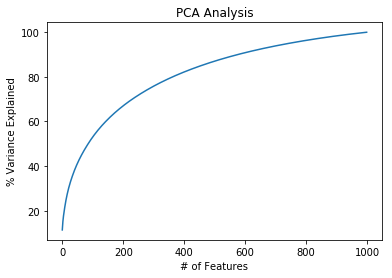

In [28]:
def plot_variance_vs_features(singular_values, cutoff):
    evr = np.array([singular_values[i]**2 / sum(singular_values**2) for i in range(cutoff)])
    var = np.cumsum(evr*100)
    plt.ylabel('% Variance Explained')
    plt.xlabel('# of Features')
    plt.title('PCA Analysis')
    plt.style.context('seaborn-whitegrid')
    plt.plot(var)
    
plot_variance_vs_features(model.projection.s, max_cutoff)

The good news is this curve is very steep in the beginning, which shows that a lot of information is conveyed in the first components. However, there is no plateau that we can use to choose a cutoff.

**So, instead, we will break off a validaton set and use classifier performance to tune this hyperparameter.**

In [29]:
def evaluate_model(X, review_times, y):
    X = np.hstack((X, review_times))
    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 195)
    rfor = RandomForestClassifier(n_estimators=51, random_state=195)
    rfor.fit(X_train, y_train)
    return rfor.score(X_test, y_test)

### Step 2.3: Choosing the number of components via the downstream task

In some ways, this method of choosing the number of components is even better than the plateau method, because we are optimizing directly on the machine learning task rather than something intrinsic to the dataset. In the cell below, we will call `evaluate model` on models between 10 and 30 PCA components. For each model, we will train an `LsiModel`, compute the $V$ matrix (right singular vectors), call `densify` on that, and pass the dense matrix to evaluate model.

In [31]:
results = []
for i in range(10,31):
    model = LsiModel(reviews_bow, i, reviews_dict)
    densified_v = densify(model[reviews_bow], i)
    results.append(evaluate_model(densified_v, reviews_times, y))

In [32]:
display(results)

[0.6691,
 0.6662,
 0.66485,
 0.6719,
 0.676,
 0.6805,
 0.68345,
 0.69185,
 0.6941,
 0.68765,
 0.6906,
 0.6858,
 0.6884,
 0.6874,
 0.6915,
 0.69165,
 0.6946,
 0.6894,
 0.69045,
 0.6908,
 0.6955]

In [30]:
# final_sppmi_test
final_sppmi = evaluate_model(vecs_sppmi, reviews_times, y)
print(final_sppmi)

0.77575


In [33]:
# final_sgns_test (5 points)
final_sgns = evaluate_model(vecs_sgns, reviews_times, y)
print(final_sgns)

0.7404


---

Note: This is one of the assignments of CIS 545 Big Data Analytics at University of Pennsylvania during Spring 2019.